In [1]:
# imports

from multipathogen_sero.io import load_metadata_json
from multipathogen_sero.config import MODEL_FITS_DIR
from multipathogen_sero.analyse_chains import *

2025-09-12 18:27:28.684 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


In [2]:
expt_settings = load_metadata_json(MODEL_FITS_DIR / "j6403" / "a1")

idata_frailty = read_fit_csv_dir(MODEL_FITS_DIR / "j6403" / "a1" / "pairwise_serology_seroreversion_frailty")
summary = basic_summary(idata_frailty)


                         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
baseline_hazards[0]      0.04  0.01    0.03     0.05       0.00     0.00   
baseline_hazards[1]      0.09  0.01    0.07     0.10       0.00     0.00   
seroreversion_rates[0]   0.08  0.01    0.06     0.10       0.00     0.00   
seroreversion_rates[1]   0.08  0.01    0.06     0.09       0.00     0.00   
betas[0]                 0.29  0.23   -0.13     0.73       0.01     0.01   
...                       ...   ...     ...      ...        ...      ...   
log_lik_test[995]       -6.34  0.27   -6.84    -5.89       0.01     0.01   
log_lik_test[996]       -7.96  0.23   -8.44    -7.58       0.01     0.00   
log_lik_test[997]       -3.41  0.34   -3.97    -2.77       0.02     0.01   
log_lik_test[998]       -9.96  0.25  -10.43    -9.52       0.01     0.01   
log_lik_test[999]      -13.48  0.29  -14.03   -12.94       0.01     0.01   

                        ess_bulk  ess_tail  r_hat  
baseline_hazards[0]      1229.54   

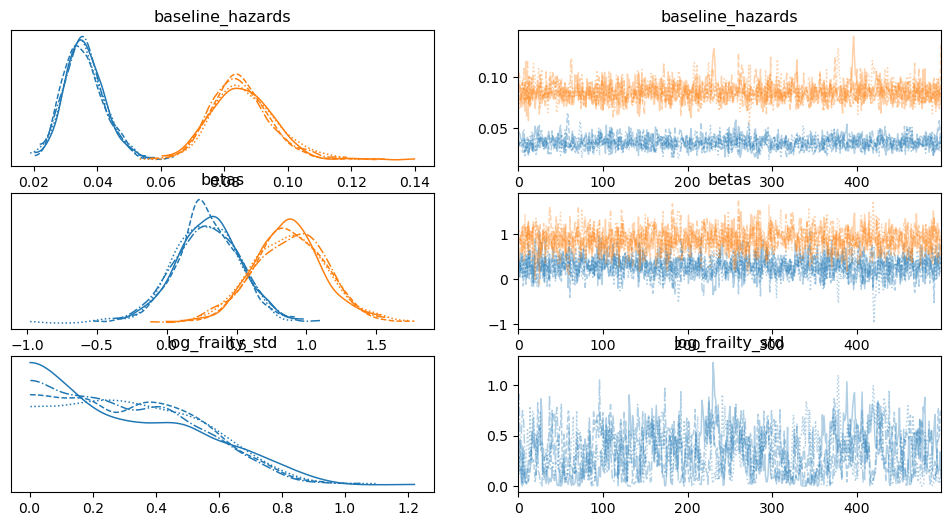

In [3]:
axes = trace_plot(idata_frailty, var_names = ["baseline_hazards", "betas", "log_frailty_std"])

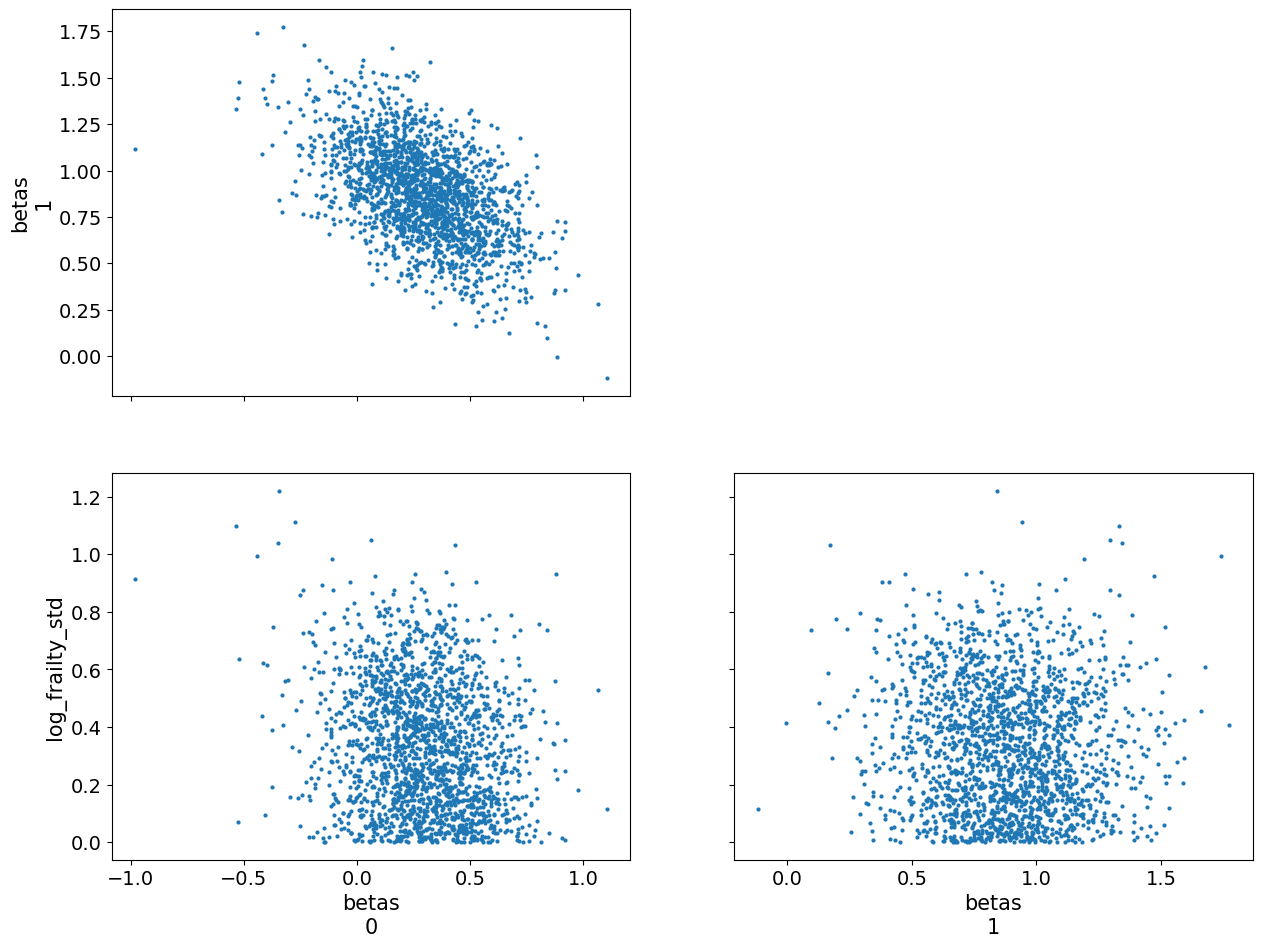

In [4]:
axes = pairs_plot(idata_frailty)

{'betas': [np.True_, np.True_], 'log_frailty_std': [np.True_], 'baseline_hazards': [np.False_, np.True_], 'seroreversion_rates': [np.False_, np.False_]}


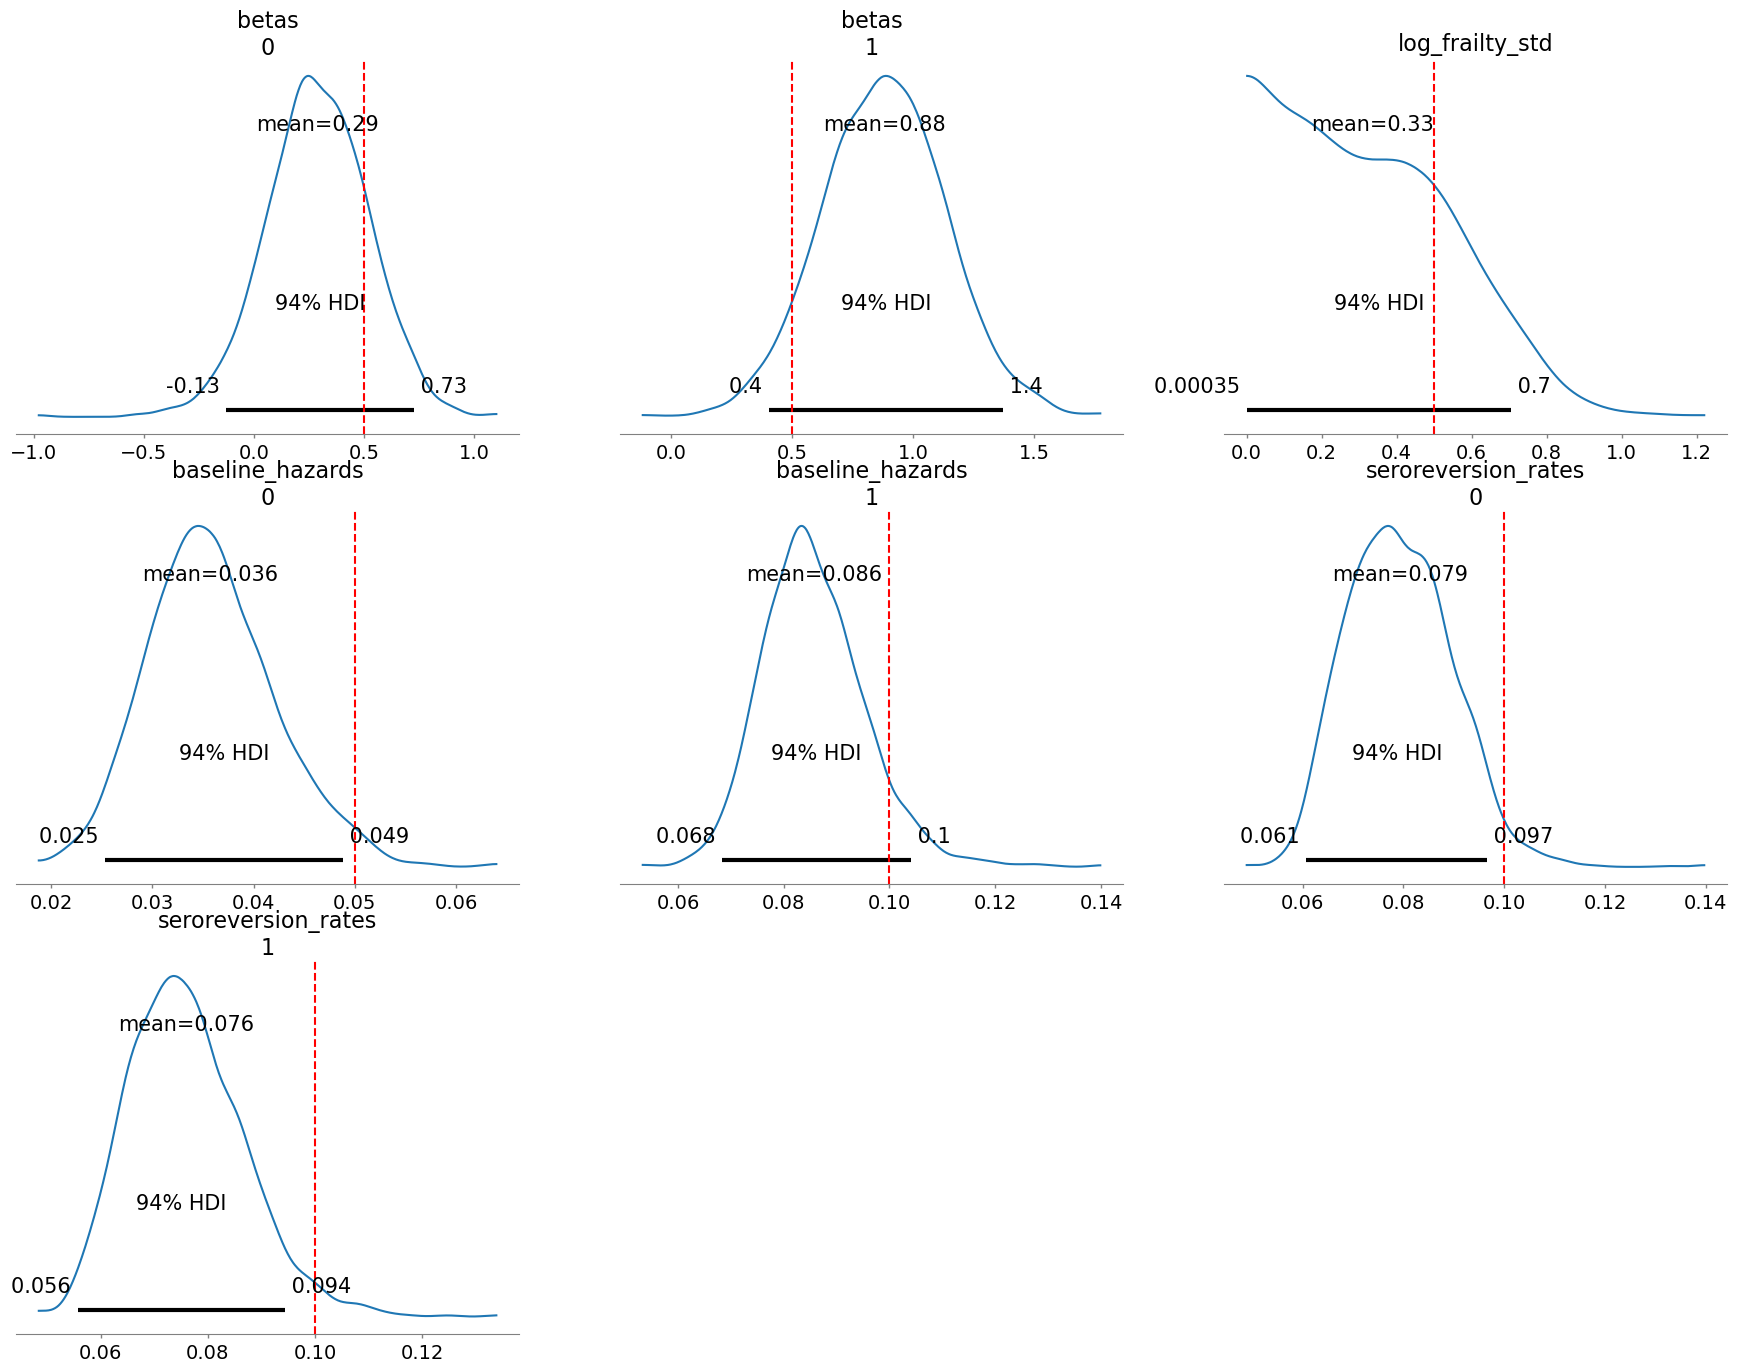

In [8]:
ground_truth_betas = [
    expt_settings["ground_truth_params"]["beta_mat"][0][1],
    expt_settings["ground_truth_params"]["beta_mat"][1][0]
]
axes, coverage = posterior_plot(
    idata_frailty, 
    var_names=["betas", "log_frailty_std", "baseline_hazards", "seroreversion_rates"],
    ground_truth={
        "betas": ground_truth_betas,
        "log_frailty_std": expt_settings["ground_truth_params"]["log_frailty_std"],
        "baseline_hazards": expt_settings["ground_truth_params"]["baseline_hazards"],
        "seroreversion_rates": expt_settings["ground_truth_params"]["seroreversion_rates"]
    }
)
print(coverage)

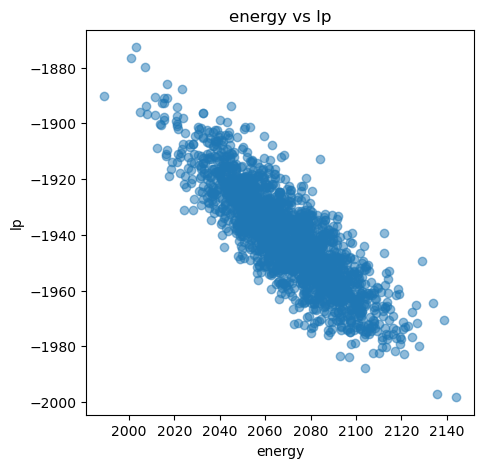

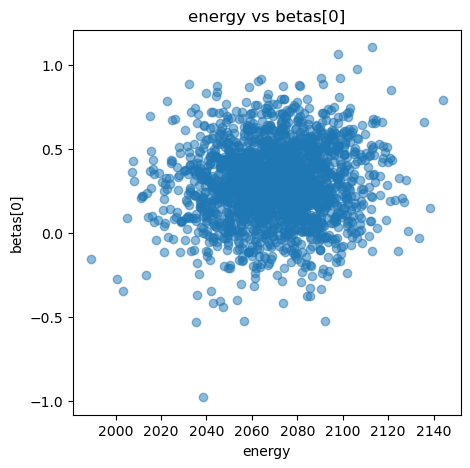

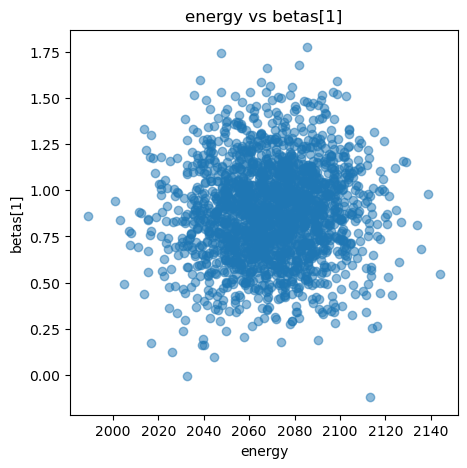

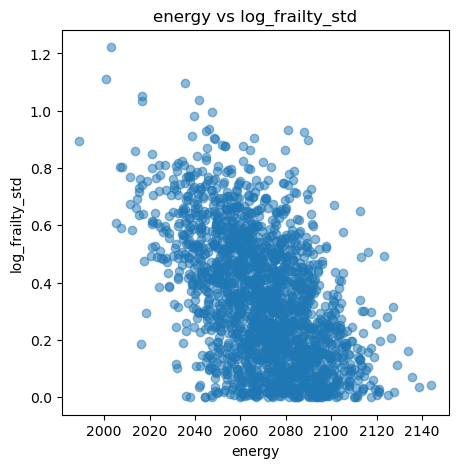

In [10]:
plot_energy_vs_lp_and_params(idata_frailty, var_names=["betas", "log_frailty_std"])

In [1]:
# imports
import time
import os

import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero.io import save_metadata_json
from multipathogen_sero.config import MODEL_FITS_DIR, STAN_DIR
from multipathogen_sero.simulate import (
    get_constant_foi,
    generate_uniform_birth_times,
    simulate_infections_seroreversion,
    simulation_to_survey_wide
)
from multipathogen_sero.analyse_chains import (
    save_fit_diagnose,
    trace_plot,
    pairs_plot,
    posterior_plot,
    elpd_using_test_set,
    compare_using_test_set
)

# N_REPEATS = 2
# TODO: 
# define the parameter grid (simulation params, random seed)

ARRAY_INDEX = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
JOB_ID = int(os.environ.get('SLURM_ARRAY_JOB_ID', 0))
HOSTNAME = os.environ.get('HOSTNAME', '')
TIMESTAMP = int(time.time()),

# initialise settings of the experiment
EXPT_SETTINGS = {
    "runtime_info": {
        "job_id": JOB_ID,
        "array_index": ARRAY_INDEX,
        "hostname": HOSTNAME,
        "timestamp": TIMESTAMP
    },
    "ground_truth_params": {
        "n_pathogens": 2,
        "baseline_hazards": [0.05, 0.10],  # TODO: choose from prior
        "seroreversion_rates": [0.1, 0.1],
        "log_frailty_std": 0.5,
        "beta_mat": [[0, 0.5], [0.5, 0]],
        "seed": 42
    },
    "train_data": {
        "n_people": 5,  # TODO: make this variable
        "t_min": 0,
        "t_max": 100,
        "survey_every": 10,
        "seed": 42 + ARRAY_INDEX
    },
    "test_data": {
        "n_people": 5,
        "t_min": 0,
        "t_max": 100,
        "survey_every": 10,
        "seed": 2411 + ARRAY_INDEX # must be different from train seed
    },
    "inference_params": {
        "log_baseline_hazard_mean": -1,
        "log_baseline_hazard_scale": 1,
        "beta_scale": 1.0,
        "seroreversion_rate_scale": 1.0,
        "log_frailty_std_scale": 1.0,  # only when frailty is modelled
        "n_frailty_samples": 20,  # number of Monte Carlo samples for integration over frailty
        "chains": 4,
        "iter_sampling": 5,
        "iter_warmup": 5,
        "seed": 42
    },
    "notes": ""
}

OUTPUT_DIR = MODEL_FITS_DIR / f"j{JOB_ID}" / f"a{ARRAY_INDEX}"
OUTPUT_DIR_FRAILTY = OUTPUT_DIR / "frailty"
OUTPUT_DIR_NO_FRAILTY = OUTPUT_DIR / "no_frailty"
os.makedirs(OUTPUT_DIR_FRAILTY, exist_ok=True)
os.makedirs(OUTPUT_DIR_NO_FRAILTY, exist_ok=True)
save_metadata_json(OUTPUT_DIR, EXPT_SETTINGS)

# simulate the data
log_frailty_covariance = (
    EXPT_SETTINGS["ground_truth_params"]["log_frailty_std"] ** 2
    * np.eye(EXPT_SETTINGS["ground_truth_params"]["n_pathogens"])
)
birth_times = generate_uniform_birth_times(
    n_people=EXPT_SETTINGS["train_data"]["n_people"],
    t_min=EXPT_SETTINGS["train_data"]["t_min"],
    t_max=EXPT_SETTINGS["train_data"]["t_max"],
    random_seed=EXPT_SETTINGS["train_data"]["seed"]
)
foi_list = [
    get_constant_foi(a=baseline_hazard) for baseline_hazard in EXPT_SETTINGS["ground_truth_params"]["baseline_hazards"]
]


infections_df = simulate_infections_seroreversion(
    n_people=EXPT_SETTINGS["train_data"]["n_people"],
    n_pathogens=EXPT_SETTINGS["ground_truth_params"]["n_pathogens"],
    foi_list=foi_list,
    birth_times=birth_times,
    end_times=EXPT_SETTINGS["train_data"]["t_max"],
    frailty_distribution="lognormal",
    log_frailty_covariance=log_frailty_covariance,
    beta_mat=EXPT_SETTINGS["ground_truth_params"]["beta_mat"],
    seroreversion_rates=EXPT_SETTINGS["ground_truth_params"]["seroreversion_rates"],
    random_seed=EXPT_SETTINGS["ground_truth_params"]["seed"]
)

survey_every = EXPT_SETTINGS["train_data"]["survey_every"]
survey_times = {
    # i + 1: survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1)
    i + 1: np.insert(
        survey_every * np.arange(np.floor(birth_times[i] / survey_every) + 1, np.floor(EXPT_SETTINGS["train_data"]["t_max"] / survey_every) + 1),
        0, birth_times[i]
    )
    for i in range(EXPT_SETTINGS["train_data"]["n_people"])
}
survey_wide = simulation_to_survey_wide(
    infections_df,
    survey_times=survey_times
)
# exclude individuals with only one row in survey_wide
survey_wide = survey_wide.groupby('individual').filter(lambda x: len(x) > 1)
n_nontrivial_individuals = len(survey_wide['individual'].unique())

birth_times_test = generate_uniform_birth_times(
    n_people=EXPT_SETTINGS["test_data"]["n_people"],
    t_min=EXPT_SETTINGS["test_data"]["t_min"],
    t_max=EXPT_SETTINGS["test_data"]["t_max"],
    random_seed=EXPT_SETTINGS["test_data"]["seed"]
)
infections_df_test = simulate_infections_seroreversion(
    n_people=EXPT_SETTINGS["test_data"]["n_people"],
    n_pathogens=EXPT_SETTINGS["ground_truth_params"]["n_pathogens"],
    foi_list=foi_list,
    birth_times=birth_times_test,
    end_times=EXPT_SETTINGS["test_data"]["t_max"],
    frailty_distribution="lognormal",
    log_frailty_covariance=log_frailty_covariance,
    beta_mat=EXPT_SETTINGS["ground_truth_params"]["beta_mat"],
    seroreversion_rates=EXPT_SETTINGS["ground_truth_params"]["seroreversion_rates"],
    random_seed=EXPT_SETTINGS["ground_truth_params"]["seed"]
)
survey_every_test = EXPT_SETTINGS["test_data"]["survey_every"]
survey_times_test = {
    # i + 1: survey_every * np.arange(np.floor(birth_times_test[i]/survey_every)+1, np.floor(t_max/survey_every)+1)
    i + 1: np.insert(
        survey_every * np.arange(np.floor(birth_times_test[i] / survey_every) + 1, np.floor(EXPT_SETTINGS["test_data"]["t_max"] / survey_every) + 1),
        0, birth_times_test[i]
    )
    for i in range(EXPT_SETTINGS["test_data"]["n_people"])
}
survey_wide_test = simulation_to_survey_wide(
    infections_df_test,
    survey_times=survey_times_test
)
survey_wide_test = survey_wide_test.groupby('individual').filter(lambda x: len(x) > 1)
n_nontrivial_individuals_test = len(survey_wide_test['individual'].unique())

# fit both models on the data
stan_data = {
    "K": EXPT_SETTINGS["ground_truth_params"]["n_pathogens"],
    "N": n_nontrivial_individuals,
    "num_obs": survey_wide.groupby('individual').size().values,
    "num_obs_total": len(survey_wide),
    "obs_times": survey_wide['time'].values,
    "serostatus": survey_wide[[col for col in survey_wide.columns if col.startswith('serostatus_')]].values.astype(int),
    "N_test": n_nontrivial_individuals_test,
    "num_obs_test": survey_wide_test.groupby('individual').size().values,
    "num_obs_total_test": len(survey_wide_test),
    "obs_times_test": survey_wide_test['time'].values,
    "serostatus_test": survey_wide_test[[col for col in survey_wide_test.columns if col.startswith('serostatus_')]].values.astype(int),
    "n_frailty_samples": EXPT_SETTINGS["inference_params"]["n_frailty_samples"],
    "log_baseline_hazard_mean": EXPT_SETTINGS["inference_params"]["log_baseline_hazard_mean"],
    "log_baseline_hazard_scale": EXPT_SETTINGS["inference_params"]["log_baseline_hazard_scale"],
    "beta_scale": EXPT_SETTINGS["inference_params"]["beta_scale"],
    "seroreversion_rate_scale": EXPT_SETTINGS["inference_params"]["seroreversion_rate_scale"],
    "log_frailty_std_scale": EXPT_SETTINGS["inference_params"]["log_frailty_std_scale"]
}
model_frailty = CmdStanModel(
    stan_file=os.path.join(STAN_DIR, "pairwise_serology_seroreversion_frailty.stan")
)

start_time = time.time()
fit_frailty = model_frailty.sample(
    data=stan_data,
    chains=EXPT_SETTINGS["inference_params"]["chains"],
    iter_sampling=EXPT_SETTINGS["inference_params"]["iter_sampling"],
    iter_warmup=EXPT_SETTINGS["inference_params"]["iter_warmup"],
    parallel_chains=EXPT_SETTINGS["inference_params"]["chains"],
    seed=EXPT_SETTINGS["inference_params"]["seed"],
    show_progress=False
)
end_time = time.time()
print(f"Fitting time: {end_time - start_time} seconds")

fit_frailty.save_csvfiles(OUTPUT_DIR / "pairwise_serology_seroreversion_frailty")
print(save_fit_diagnose(fit_frailty, OUTPUT_DIR / "pairwise_serology_seroreversion_frailty"))

# repeat for other fit
model_no_frailty = CmdStanModel(
    stan_file=os.path.join(STAN_DIR, "pairwise_serology_seroreversion.stan")
)
start_time = time.time()
fit_no_frailty = model_no_frailty.sample(
    data=stan_data,
    chains=EXPT_SETTINGS["inference_params"]["chains"],
    iter_sampling=EXPT_SETTINGS["inference_params"]["iter_sampling"],
    iter_warmup=EXPT_SETTINGS["inference_params"]["iter_warmup"],
    parallel_chains=EXPT_SETTINGS["inference_params"]["chains"],
    seed=EXPT_SETTINGS["inference_params"]["seed"],
    show_progress=False
)
end_time = time.time()
print(f"Fitting time: {end_time - start_time} seconds")



2025-09-12 19:01:32.177 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero
19:01:32 - cmdstanpy - INFO - CmdStan start processing
19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:32 - cmdstanpy - INFO - Chain [2] start processing
19:01:32 - cmdstanpy - INFO - Chain [3] start processing
19:01:32 - cmdstanpy - INFO - Chain [4] start processing
19:01:32 - cmdstanpy - INFO - Chain [4] done processing
19:01:32 - cmdstanpy - INFO - Chain [1] done processing
19:01:32 - cmdstanpy - INFO - Chain [2] done processing
19:02:53 - cmdstanpy - INFO - Chain [3] done processing
19:02:53 - cmdstanpy - INFO - CmdStan start processing
19:02:53 - cmdstanpy - INFO - Chain [1] start processing
19:02:53 - cmdstanpy - INFO - Chain [2] start processing
19:02:53 - cmdstanpy - INFO - Chain [3] start processing
19:02:53 - cmdstanpy - INFO - Chain [4] start processing
19:02:53 - cmdstanpy - INFO - Chain [4] done processing
19:02:53 - cmdstanpy - 

Fitting time: 80.77621388435364 seconds
Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  log_lik_test[1], log_lik_test[2], log_lik_test[4], log_lik_test[5]
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more effective parameterization.

Processing complete.



19:02:53 - cmdstanpy - INFO - Chain [2] done processing
19:02:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 2 divergent transitions (40.0%)
	Chain 4 had 1 divergent transitions (20.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Fitting time: 0.1501295566558838 seconds


/home/ayan/anaconda3/envs/multipathogen-sero/lib/python3.11/site-packages/numpy/_core/_methods.py:190: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


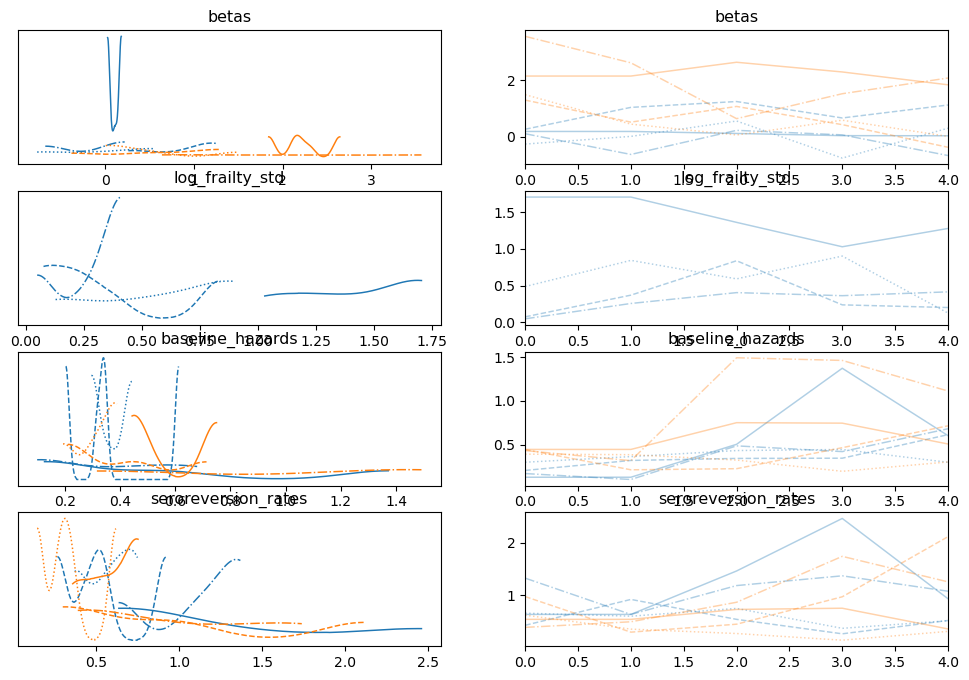

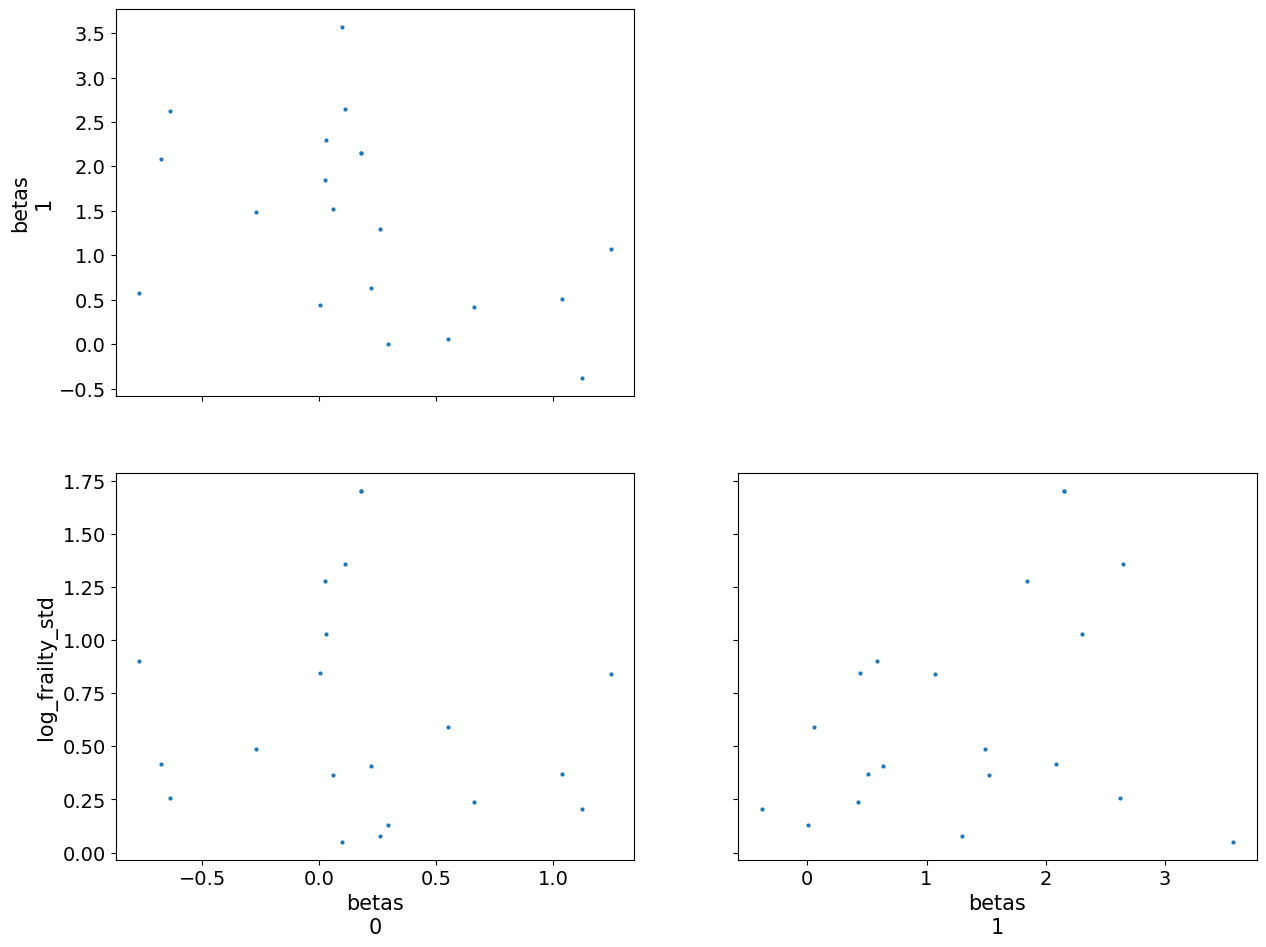

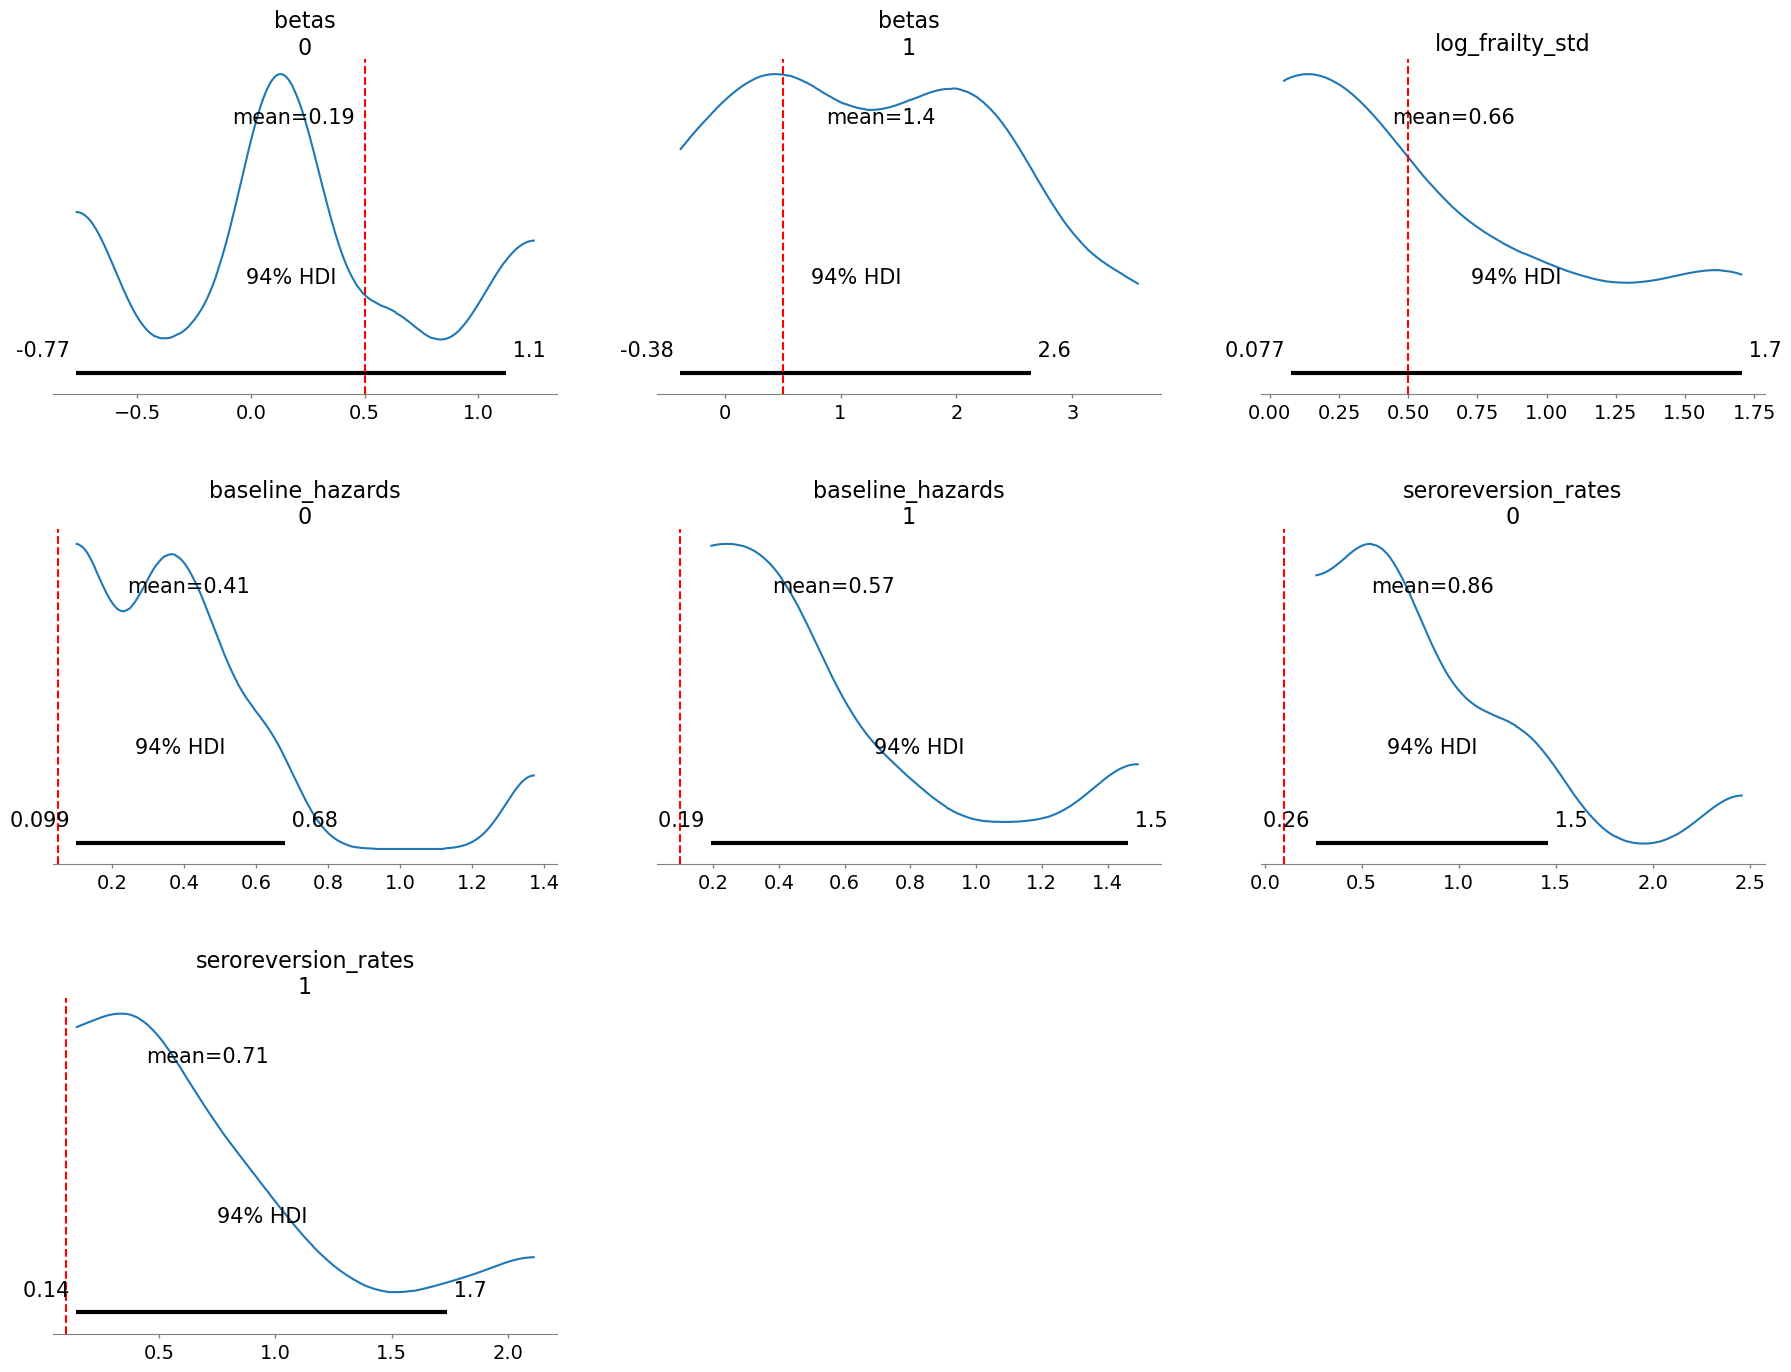

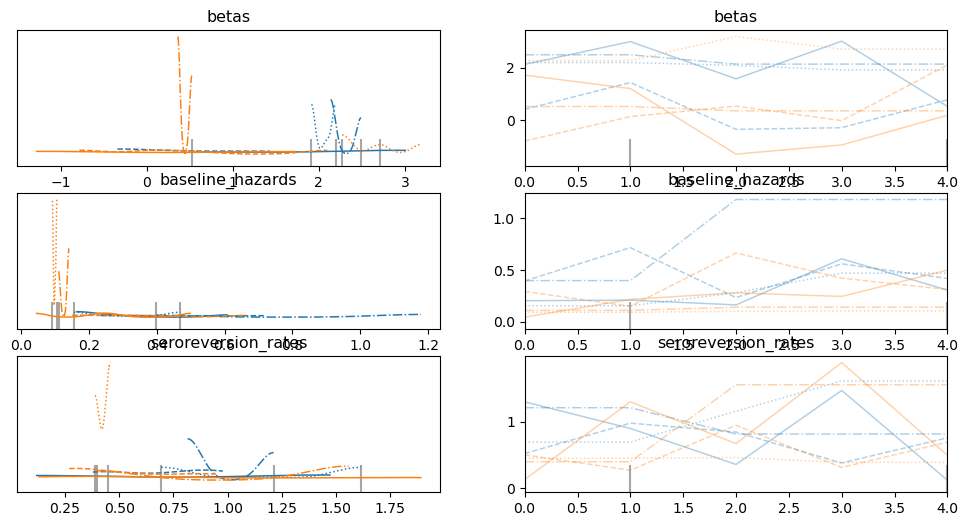

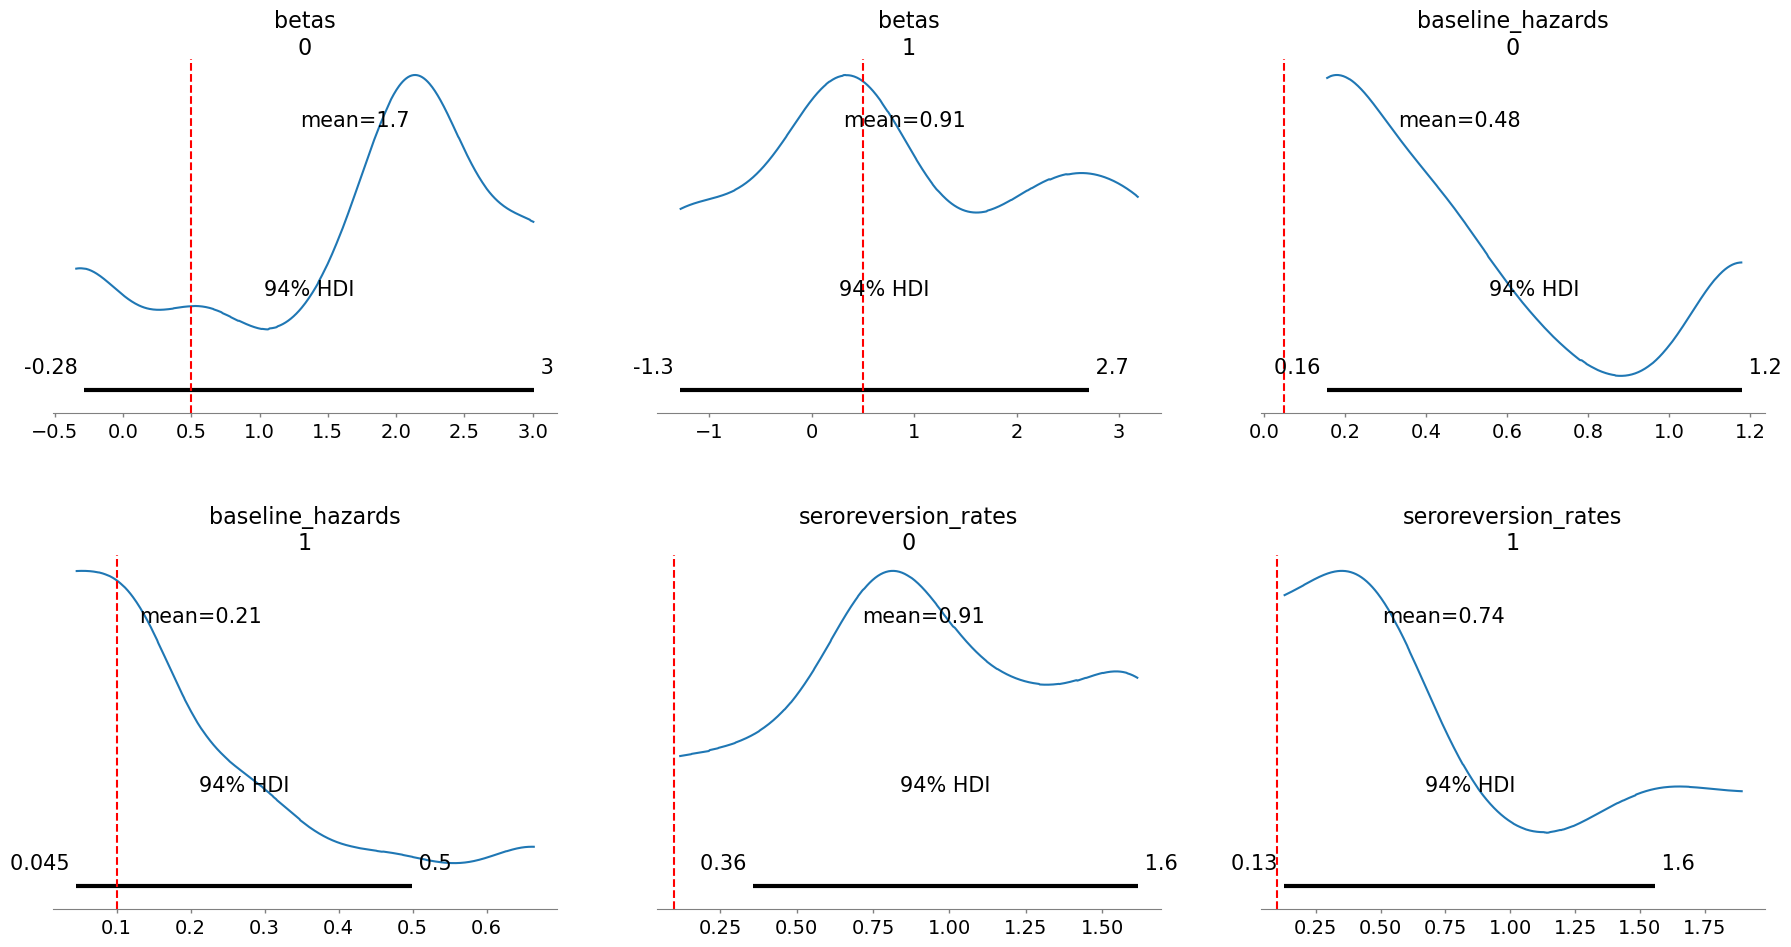

In [4]:
# save relevant plots
idata_frailty = az.from_cmdstanpy(fit_frailty)
idata_no_frailty = az.from_cmdstanpy(fit_no_frailty)
trace_plot(
    idata_frailty,
    var_names=["betas", "log_frailty_std", "baseline_hazards", "seroreversion_rates"],
    save_dir=OUTPUT_DIR_FRAILTY
)
pairs_plot(
    idata_frailty,
    var_names=["betas", "log_frailty_std"],
    save_dir=OUTPUT_DIR_FRAILTY
)
ground_truth_betas = [
    EXPT_SETTINGS["ground_truth_params"]["beta_mat"][0][1],
    EXPT_SETTINGS["ground_truth_params"]["beta_mat"][1][0]
]
axes, coverage = posterior_plot(
    idata_frailty, 
    var_names=["betas", "log_frailty_std", "baseline_hazards", "seroreversion_rates"],
    ground_truth={
        "betas": ground_truth_betas,
        "log_frailty_std": EXPT_SETTINGS["ground_truth_params"]["log_frailty_std"],
        "baseline_hazards": EXPT_SETTINGS["ground_truth_params"]["baseline_hazards"],
        "seroreversion_rates": EXPT_SETTINGS["ground_truth_params"]["seroreversion_rates"]
    },
    save_dir=OUTPUT_DIR_FRAILTY
)
trace_plot(
    idata_no_frailty,
    var_names=["betas", "baseline_hazards", "seroreversion_rates"],
    save_dir=OUTPUT_DIR_FRAILTY
)
posterior_plot(
    idata_no_frailty, 
    var_names=["betas", "baseline_hazards", "seroreversion_rates"],
    ground_truth={
        "betas": ground_truth_betas,
        "baseline_hazards": EXPT_SETTINGS["ground_truth_params"]["baseline_hazards"],
        "seroreversion_rates": EXPT_SETTINGS["ground_truth_params"]["seroreversion_rates"]
    },
    save_dir=OUTPUT_DIR_FRAILTY
)
# do elpd
elpd_frailty, se_elpd_frailty, _ = elpd_using_test_set(
    idata_frailty
)
elpd_no_frailty, se_elpd_no_frailty, _ = elpd_using_test_set(
    idata_no_frailty
)
elpd_diff, se_elpd_diff = compare_using_test_set(
    idata_frailty,
    idata_no_frailty
)
elpd_report = f"""
elpd (frailty model): {elpd_frailty} (SE: {se_elpd_frailty})
elpd (no frailty model): {elpd_no_frailty} (SE: {se_elpd_no_frailty})
elpd difference (frailty - no frailty): {elpd_diff} (SE: {se_elpd_diff})
"""
with open(OUTPUT_DIR / "elpd_report.txt", "w") as f:
    f.write(elpd_report)

In [6]:
print(elpd_report)


elpd (frailty model): -41.857296667690136 (SE: 8.04433827689827)
elpd (no frailty model): -inf (SE: nan)
elpd difference (frailty - no frailty): inf (SE: nan)

